# Model SureVenir

Surevenir is designed to solve the issue of souvenir price scams by recognizing the item through scanning. Once scanned, the app provides the souvenir’s name, description, places to buy, and an accurate price range, ensuring tourists are informed and can avoid overpaying.




## Imports Library

In [6]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop


## Prepare the Dataset

In [ ]:
# Define the path of dataset directory
dataset_path  = "./dataset"

In [8]:
# Parameters for preprocessing
img_height, img_width = 224, 224  # The target height and width for image resizing

def load_and_preprocess_data(directory):
    """
    Load and preprocess image data from a given directory.
    - Images are resized to a fixed size (224x224 in this case).
    - Labels are encoded into one-hot format.
    """
    images = []  
    labels = [] 
    class_counts = {}  
    class_names = sorted(os.listdir(directory))  
    class_labels = {class_name: idx for idx, class_name in enumerate(class_names)}  

    for class_name, label in class_labels.items():
        class_folder = os.path.join(directory, class_name)  
        class_counts[class_name] = 0  

        # Loop through all files in the class folder
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)  
            try:
                # Open the image, convert to RGB format, resize, and normalize pixel values
                image = Image.open(file_path).convert("RGB")
                image = image.resize((img_width, img_height))
                image_array = np.array(image, dtype=np.float32) / 255.0  # Normalize to [0, 1]
                images.append(image_array)  # Add the image to the list
                labels.append(label)  # Add the corresponding label
                class_counts[class_name] += 1  
            except Exception as e:
                # Handle any errors that occur during image loading or processing
                print(f"Error loading image {file_path}: {e}")

    num_classes = len(class_names)  # Calculate the total number of classes
    labels_one_hot = np.eye(num_classes)[labels]  # Convert labels to one-hot encoding

    # Return the processed data along with metadata
    return np.array(images), labels_one_hot, class_labels, class_counts

# Load and preprocess the dataset
images, labels_one_hot, class_labels, class_counts = load_and_preprocess_data(dataset_path)

# Metadata about the dataset
total_images = len(images) 
shape_images = images.shape  
shape_labels = labels_one_hot.shape 

# Convert class counts into a DataFrame for better readability
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class Name', 'Number of Images'])

# Print metadata and class-wise image distribution
print(f"Total images: {total_images}")
print(f"Shape of image data: {shape_images}")
print(f"Shape of label data: {shape_labels}")
print(f"Class labels (numeric): {class_labels}")
print("\nNumber of images per class:")
print(class_counts_df)


Total images: 6690
Shape of image data: (6690, 224, 224, 3)
Shape of label data: (6690, 21)
Class labels (numeric): {'Aromatherapy Candle': 0, 'Balinese Topeng': 1, 'Barong T-shirt': 2, 'Beach Hat Bali': 3, 'Beach Sarong': 4, 'Beads Bracelet': 5, 'Bintang T-shirt': 6, 'Coconut Shell Candle Holder': 7, 'Crochet Bag': 8, 'Dream Catcher': 9, 'Hair Clip': 10, 'Handy Fan': 11, 'Keben (Balinese Woven Box)': 12, 'Keychain': 13, 'Rattan bag': 14, 'Silver Earrings': 15, 'Tridatu Bracelet': 16, 'Udeng (Balinese Headgear)': 17, 'Wall Decoration': 18, 'Wooden Earrings': 19, 'Woven Bag': 20}

Number of images per class:
                     Class Name  Number of Images
0           Aromatherapy Candle               305
1               Balinese Topeng               311
2                Barong T-shirt               300
3                Beach Hat Bali               401
4                  Beach Sarong               301
5                Beads Bracelet               307
6               Bintang T-shirt    

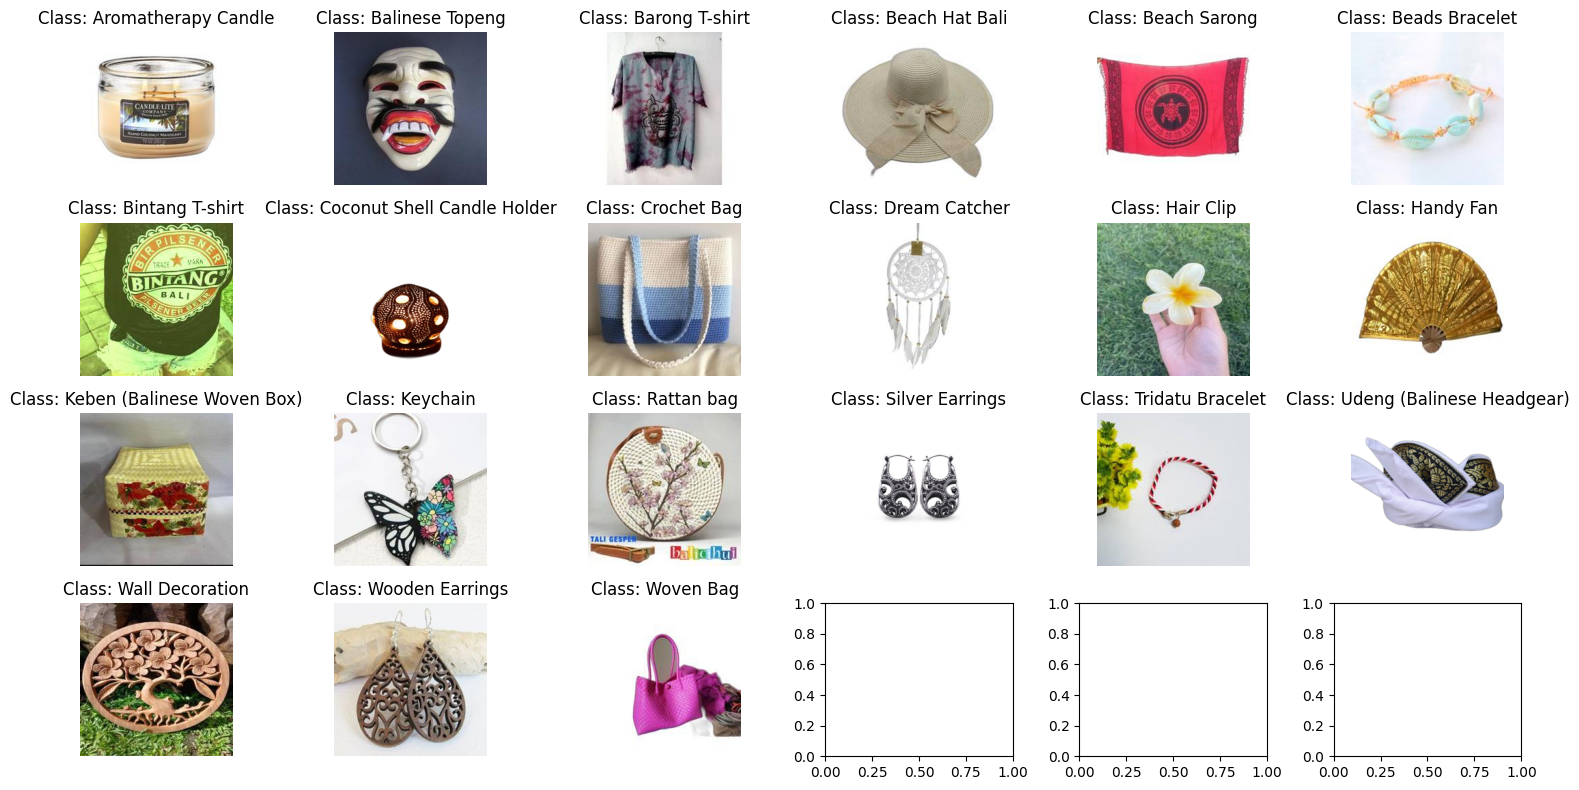

In [9]:
# Visualize the dataset by displaying one sample image per class in a grid layout.
fig, axes = plt.subplots(4, 6, figsize=(15, 8))  
axes = axes.flatten()  


for idx, (class_name, class_label) in enumerate(class_labels.items()):
    if idx >= len(axes):  
        break
    
    class_indices = np.where(np.argmax(labels_one_hot, axis=1) == class_label)[0]
    if len(class_indices) == 0:
        continue
    
    img = images[class_indices[0]]
    axes[idx].imshow(img)
    axes[idx].set_title(f'Class: {class_name}')
    axes[idx].axis('off')  

plt.tight_layout()
plt.show()

SPLIT THE DATASET


In [10]:
def split_data(images, labels, class_labels, dataset_path, split_ratio=(0.80, 0.20)):
    # Validate that the split ratio sums to 1.0
    if sum(split_ratio) != 1.0:
        raise ValueError("Split ratio must add up to 1.0.")

    # Define paths for train and test datasets
    train_path = os.path.join(dataset_path, 'train')
    test_path = os.path.join(dataset_path, 'test')

    # Create directories for train and test sets if they don't exist
    for path in [train_path, test_path]:
        os.makedirs(path, exist_ok=True)

    # Split the dataset into training and testing subsets
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=split_ratio[1], stratify=labels)

    # Helper function to save images into class-specific folders
    def save_images(images, labels, folder_path):
        for idx, image in enumerate(images):
        
            image = (image * 255).astype(np.uint8)
            label_index = np.argmax(labels[idx])  
            class_name = [name for name, value in class_labels.items() if value == label_index][0]
            class_folder = os.path.join(folder_path, class_name)
            os.makedirs(class_folder, exist_ok=True)
            image_path = os.path.join(class_folder, f"{idx}.jpg")
            Image.fromarray(image).save(image_path)

    # Save training images to the 'train' folder
    save_images(train_images, train_labels, train_path)
    # Save testing images to the 'test' folder
    save_images(test_images, test_labels, test_path)

    # Print the number of images in each split
    print(f"Data successfully split into folders:\n- Train: {len(train_images)}\n- Test: {len(test_images)}")

# Split and save the dataset
split_data(images, labels_one_hot, class_labels, dataset_path)


Data successfully split into folders:
- Train: 5352
- Test: 1338


In [11]:
# Visualize split data distribution per Category

def calculate_data_distribution(directory):
    class_counts = {}
    class_names = sorted(os.listdir(directory))
    
    for class_name in class_names:
        class_folder = os.path.join(directory, class_name)  
        if os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            class_counts[class_name] = num_images
    return class_counts

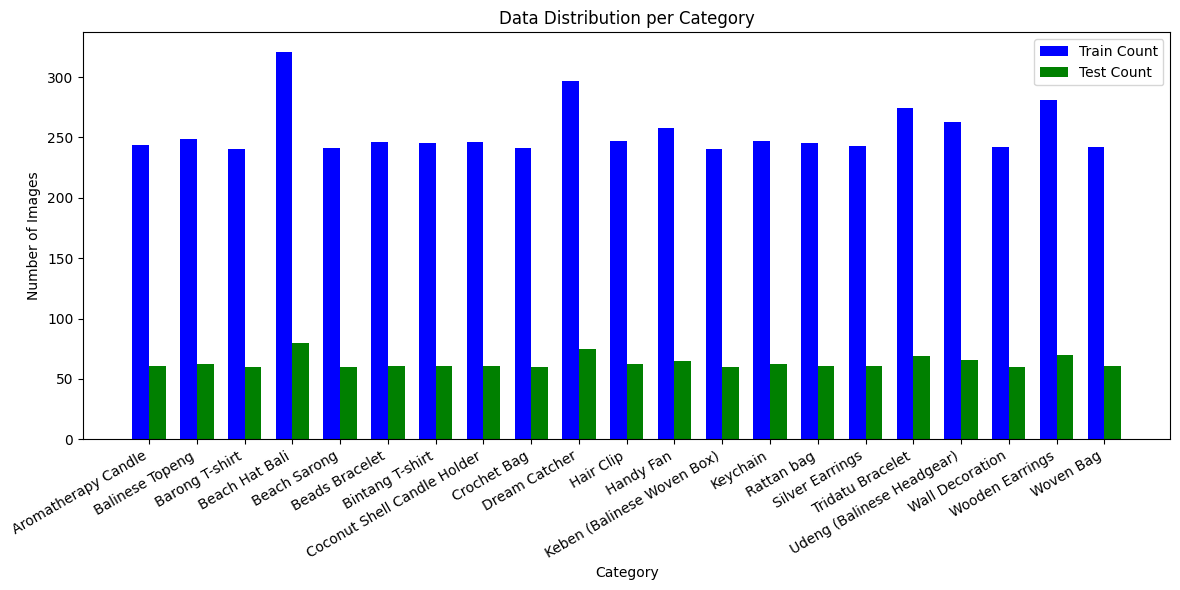

In [12]:
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

train_counts = calculate_data_distribution(train_path)
test_counts = calculate_data_distribution(test_path)

categories = list(train_counts.keys())
train_values = [train_counts.get(cat, 0) for cat in categories]
test_values = [test_counts.get(cat, 0) for cat in categories]

x = np.arange(len(categories))  
width = 0.35  

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_values, width, label='Train Count', color='blue')
plt.bar(x + width/2, test_values, width, label='Test Count', color='green')

plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Data Distribution per Category')
plt.xticks(x, categories, rotation=30, ha='right')
plt.legend()
plt.tight_layout()

plt.show()

DATA AUGMENTASI


In [13]:
# Define paths to the training and testing directories
train_dir = os.path.join(dataset_path, 'train')  
test_dir = os.path.join(dataset_path, 'test')   

# Configure data augmentation for the training dataset
training_datagen = ImageDataGenerator(
    rescale=1.0 / 255,              # Normalize pixel values to [0, 1]
    rotation_range=20,              # Randomly rotate images within a 20-degree range
    horizontal_flip=True,           # Randomly flip images horizontally
    brightness_range=[0.5, 1.5],    # Randomly adjust image brightness
    channel_shift_range=50.0,       # Randomly shift color channels
    shear_range=0.2,                # Apply shear transformations
    zoom_range=0.2,                 # Randomly zoom into images
    width_shift_range=0.2,          # Randomly shift images horizontally
    height_shift_range=0.2,         # Randomly shift images vertically
    fill_mode='nearest'             # Fill any empty pixels with the nearest pixel value
)

# Configure data preprocessing for the validation dataset (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)  

# Create the training data generator
train_generator = training_datagen.flow_from_directory(
    train_dir,                 
    target_size=(img_height, img_width),  
    class_mode='categorical',      
    batch_size=64            
)

# Create the validation data generator
validation_generator = validation_datagen.flow_from_directory(
    test_dir,                       
    target_size=(img_height, img_width),  
    class_mode='categorical',  
    batch_size=64                
)


print("Training and validation datasets are ready..")

Found 5352 images belonging to 21 classes.
Found 1338 images belonging to 21 classes.
Training and validation datasets are ready..


## Build the Model

In [14]:
# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(img_height, img_width, 3))

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

# Build a new model on top of the pre-trained base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(21, activation='softmax')
])

# Print the model summary
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 21)                10773     
                                                                 
Total params: 2924629 (11.16 MB)
Trainable params: 666

In [15]:
model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [16]:
history = model.fit(
    train_generator,
    epochs=35,  
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

Epoch 1/35


84/84 [==============================] - 120s 1s/step - loss: 1.9946 - accuracy: 0.4651 - val_loss: 0.8807 - val_accuracy: 0.8401
Epoch 2/35
84/84 [==============================] - 188s 2s/step - loss: 0.8633 - accuracy: 0.7790 - val_loss: 0.4485 - val_accuracy: 0.8999
Epoch 3/35
84/84 [==============================] - 128s 2s/step - loss: 0.5875 - accuracy: 0.8399 - val_loss: 0.3235 - val_accuracy: 0.9148
Epoch 4/35
84/84 [==============================] - 87s 1s/step - loss: 0.4593 - accuracy: 0.8735 - val_loss: 0.2662 - val_accuracy: 0.9238
Epoch 5/35
84/84 [==============================] - 160s 2s/step - loss: 0.3943 - accuracy: 0.8896 - val_loss: 0.2344 - val_accuracy: 0.9365
Epoch 6/35
84/84 [==============================] - 219s 3s/step - loss: 0.3555 - accuracy: 0.8959 - val_loss: 0.2064 - val_accuracy: 0.9387
Epoch 7/35
84/84 [==============================] - 108s 1s/step - loss: 0.3017 - accuracy: 0.9150 - val_loss: 0.1911 - val_accuracy: 0.9447
Epoch 8/35
8

In [17]:
# Evaluate on the test dataset
test_loss, test_acc = model.evaluate(validation_generator)  
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss * 100:.2f}%")

21/21 [==============================] - 16s 754ms/step - loss: 0.1100 - accuracy: 0.9619
Test accuracy: 96.19%
Test loss: 11.00%


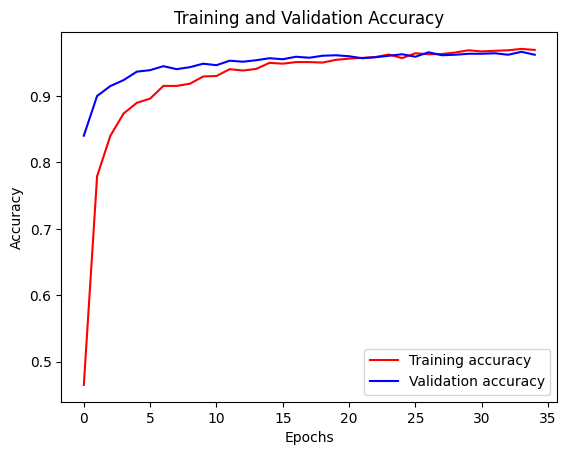

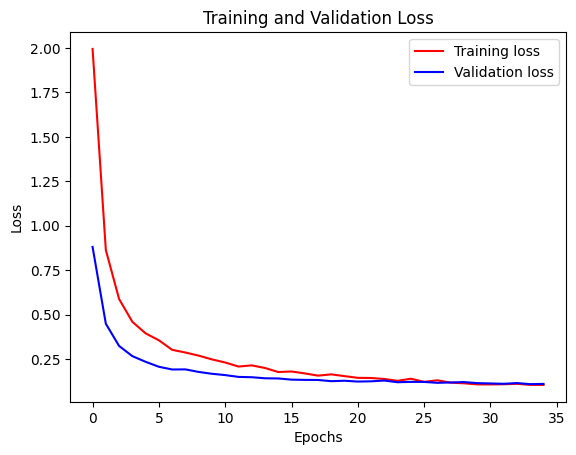

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

# Plot Training and Validation Accuracy
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Training and Validation Loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

## Saving the Model

In [19]:
# Save model with h5 file
model.save('model-souvenir-bali.h5')

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluate the Model

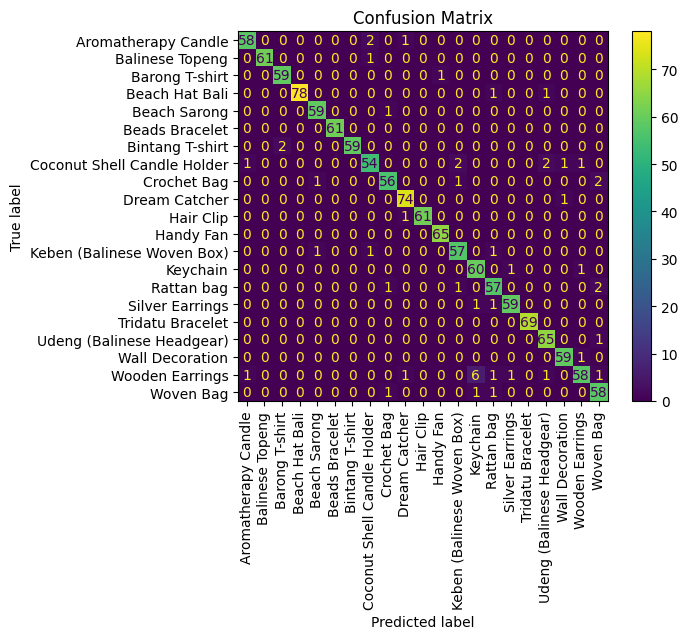

In [20]:
y_true = []
y_pred = []

for batch_images, batch_labels in validation_generator:

    predictions = model.predict(batch_images, verbose=0)
    
    y_true.extend(np.argmax(batch_labels, axis=1))
    
    y_pred.extend(np.argmax(predictions, axis=1))
    
    if len(y_true) >= validation_generator.samples:
        break

classes = {v: k for k, v in validation_generator.class_indices.items()}

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))
disp.plot(cmap="viridis", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

In [21]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=list(classes.values()))
print("Classification Report:")
print(report)

Classification Report:
                             precision    recall  f1-score   support

        Aromatherapy Candle       0.97      0.95      0.96        61
            Balinese Topeng       1.00      0.98      0.99        62
             Barong T-shirt       0.97      0.98      0.98        60
             Beach Hat Bali       1.00      0.97      0.99        80
               Beach Sarong       0.97      0.98      0.98        60
             Beads Bracelet       1.00      1.00      1.00        61
            Bintang T-shirt       1.00      0.97      0.98        61
Coconut Shell Candle Holder       0.93      0.89      0.91        61
                Crochet Bag       0.95      0.93      0.94        60
              Dream Catcher       0.96      0.99      0.97        75
                  Hair Clip       1.00      0.98      0.99        62
                  Handy Fan       0.98      1.00      0.99        65
 Keben (Balinese Woven Box)       0.93      0.95      0.94        60
          

In [ ]:
import json
import numpy as np
import tensorflow as tf
from PIL import Image

# Load classes with the updated order
classes = {
    0: "aromatherapy-candle",
    1: "balinese-topeng",
    2: "barong-t-shirt",
    3: "beach-hat-bali",
    4: "beach-sarong",
    5: "beads-bracelet",
    6: "bintang-t-shirt",
    7: "coconut-shell-candle-holder",
    8: "crochet-bag",
    9: "dream-catcher",
    10: "hair-clip",
    11: "handy-fan",
    12: "keben-balinese-woven-box",
    13: "keychain",
    14: "rattan-bag",
    15: "silver-earrings",
    16: "tridatu-bracelet",
    17: "udeng-balinese-headgear",
    18: "wall-decoration",
    19: "wooden-earrings",
    20: "woven-bag"
}

# Function to load JSON data
def load_json(file_path):
    try:
        with open(file_path, "r") as file:
            data = json.load(file)
        # Create a dictionary with numeric ID as keys
        return {idx: item for idx, item in enumerate(data)}
    except Exception as e:
        print(f"Error loading JSON: {e}")
        return {}

# Load the model
try:
    model = tf.keras.models.load_model("model-souvenir-bali.h5")
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Function to predict image
def predict_image(image_path, threshold=0.5):
    try:
        image = Image.open(image_path).convert("RGB")
        image = image.resize((224, 224))  
        image_array = tf.keras.utils.img_to_array(image) / 255.0  
        image_array = np.expand_dims(image_array, axis=0)  

        prediction = model.predict(image_array, verbose=0)[0]
        
        # Get the maximum confidence and its corresponding class ID
        confidence = np.max(prediction)
        predicted_class_id = np.argmax(prediction)

        if confidence < threshold:
            return "undefined", None, confidence

        predicted_class = classes[predicted_class_id]
        return predicted_class, predicted_class_id, confidence
    except Exception as e:
        return f"Error: {e}", None, None

# Load JSON data
descriptions = load_json("description.json")

# Test with an image path
image_path = "predict7.jpg"
predicted_class, predicted_class_id, confidence = predict_image(image_path, threshold=0.5)

# Print results
if confidence is not None:
    if predicted_class == "undefined":
        print(f"\nPrediction confidence is below the threshold. Result: {predicted_class}")
    else:
        print(f"\nPredicted Class: {predicted_class}")
        print(f"Confidence: {confidence * 100:.2f}%")

        # Get item details from JSON using the predicted class ID
        if predicted_class_id in descriptions:
            item = descriptions[predicted_class_id]
            print(f"Name: {item['Name']}")
            print(f"Description: {item['Description']}")
            print(f"Price Range: {item['Price Range']}")
            print(f"Purchase Location: {item['Purchase Location']}")
        else:
            print("No matching item found in the JSON file.")
else:
    print(predicted_class)



Predicted Class: barong-t-shirt
Confidence: 99.98%
Name: Barong T-shirt
Description: The Barong T-Shirt is a unique and stylish garment that features the iconic Barong, a mythical creature symbolizing protection and good spirits in Balinese culture. Crafted from high-quality rayon material, this t-shirt is soft, lightweight, and perfect for casual wear or as a meaningful souvenir from Bali.

Available in a variety of sizes to ensure the perfect fit:

- S: Width: 50cm, Length 55cm
- M: Width: 52cm, Length 58cm
- L: Width 54cm, Length 64cm
- XL: Width 55cm, Length 69cm
- XXL: Width 62cm, Length 75cm
- XXXL: Width 65cm, Length 77cm

With a price range of 30,000 IDR to 50,000 IDR, the Barong T-Shirt offers exceptional value and cultural significance. Ideal for those who appreciate Bali's rich traditions and timeless art, this t-shirt is a must-have for your collection or as a thoughtful gift for loved ones.
Price Range: 30.000 IDR - 50.000 IDR
Purchase Location: Ubud Market
